# Style Transfer with Convolutional Neural Networks

In [1]:
import torchvision.models as models
from importlib import reload
import torch
import numpy as np
from torch.optim import LBFGS, SGD
import torch.nn as nn
from __future__ import print_function
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd

import matplotlib.pyplot as plt
import pdb
import copy
from torchvision.models.densenet import _Transition, _DenseBlock

%matplotlib inline

# Pretrained model and relevant indexes

In [22]:
densenet = models.vgg16(pretrained=True)

In [3]:
transition_indexes = [ index for index, l in enumerate(densenet.features) if type(l) is _Transition ]
print(transition_indexes)

[5, 7, 9]


# Content Loss

In [4]:
class ContentLoss(nn.Module):
    def __init__(self, weight, target):
        super(ContentLoss, self).__init__()        
        self.target = target.detach()
        self.weight = weight
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        self.output = input.clone()        
        self.loss = self.loss_fn(input, self.target)
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


# Style Loss

In [5]:
class GramMatrix(nn.Module):
    def forward(self, input):
        batch_size, height, width, chan = input.size()
        flattened_channels = input.view(batch_size * chan, width * height)
        g_matrix = torch.mm(flattened_channels, flattened_channels.t())
        return g_matrix.div(flattened_channels.nelement() / 1000)

class StyleLoss(nn.Module):
    def __init__(self, weight, target):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.loss_fn(self.G, self.target)
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss     

# Building Style Transfer model

In [6]:
def set_training_false_dense_block(block):
    block.training = False    
    if type(block) == nn.BatchNorm2d:
        block.affine = False        

def build_model(cnn, content_layers, style_layers, content_image, style_image):
    content_losses = []
    style_losses = []
    model = nn.Sequential()
    cnn = copy.deepcopy(cnn).cuda()
    gram = GramMatrix()
    
    for index, layer in enumerate(cnn.features):
        if type(layer) is _Transition:
            for i2, l2 in enumerate(list(layer.modules())[1:]):
                model.add_module("transition_layer_{}_{}".format(i2, index), l2)
                if type(l2) == nn.Conv2d:
                    print("Adding content loss transition: {}, {}".format(index, i2))
                    target = model(content_image.unsqueeze(0)).clone()
                    content_loss = ContentLoss(content_layers[index], target)
                    content_losses.append(content_loss)
                    model.add_module("layer_{}_content_loss_transition".format((i2 + 1) * (index + 1)), content_loss)    
        else:
            model.add_module("layer_{}".format(index), layer)
    model = model.cuda()
    
    for p in model.parameters():
        p.requires_grad = False
        
    model.apply(set_training_false_dense_block)
    return model, content_losses, style_losses
print("Done")

Done


In [7]:
def run_epochs(model, count, img, optimizer, s_losses, c_losses, print_every=100):
    elapsed_epochs = 0
    for i in range(count):
        img.data.clamp_(0,1)
        model.zero_grad()
        optimizer.zero_grad()
        elapsed_epochs += 1
        prediction = img.unsqueeze(0)
        model(prediction)
        
#        s_loss = sum([ s.backward() for s in s_losses ])
        c_loss = sum([ c.backward() for c in c_losses ])
        optimizer.step()
        style_loss =  0# s_loss.data[0]
        content_loss = c_loss.data[0]
        
        if i % print_every == 0:
            print("Epoch #{} Content Loss: {} Style Loss: {} Total Loss: {}".format(str(i), content_loss, style_loss, content_loss + style_loss ))
    img.data.clamp_(0,1)

In [8]:
def build_optimizer(starting_img, lr=1):
    img_param = torch.randn(starting_img.size())
    img_param[0] = 0.5
    img_param[1] = 0.5
    img_param[2] = 0.5
    img_param = nn.Parameter(img_param)
    img_param = img_param.cuda().clone().detach()
    img_param.requires_grad = True
    optimizer = SGD([img_param], lr=lr)
    return img_param, optimizer


# Experiments

In [9]:
content_layers = {
    5: 900,
    7: 1300,
    9: 1800
}
#0, 6, 9, 13, 16
style_layers = {
    5: 900,
    7: 1300,
    9: 1800
}


In [10]:
from torchvision.transforms import ToPILImage
unloader = ToPILImage()
def unload(img):
    img = img.data
    img = img.clone().cpu()
    img = unloader(img)
    return img

def show_results(content_image, style_image, img):
    content_img = unload(content_image)
    style_img = unload(style_image)
    result_img = unload(img)
    
    f, axis = plt.subplots(1,3)
    f.set_size_inches(20, 5)
    axis[0].imshow(content_img)
    axis[1].imshow(style_img)
    axis[2].imshow(result_img)    

## #1

In [11]:
import matplotlib.image as mpimg
import matplotlib as mpl
mpl.rc("savefig", dpi=160)

In [12]:
#img = mpimg.imread("data/content/Amanda.jpg")
#plt.imshow(img)

In [13]:
#img = mpimg.imread("data/style/morgan-sketch-3.jpg")
#plt.imshow(img)

torch.Size([3, 800, 800])
torch.Size([3, 800, 800])


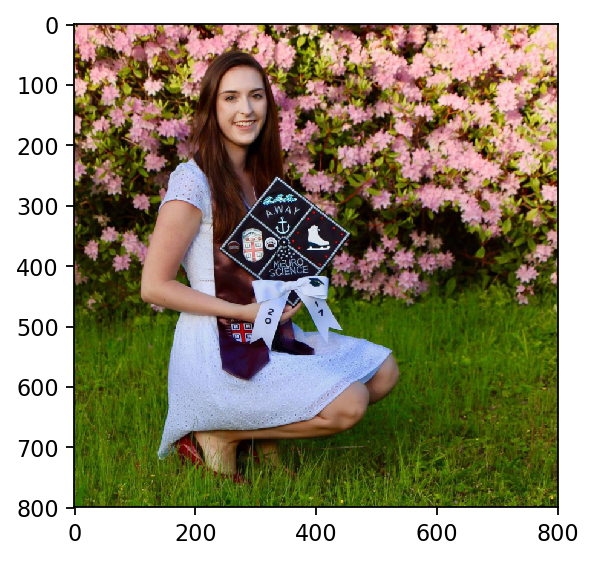

In [21]:
style_image  = Variable(U.get_image(16, 302, None, 800)).cuda()
content_image = Variable(U.get_image(0, None, None, 800)).cuda()
print(style_image.size())
print(content_image.size())
U.imshow(content_image.data)

In [15]:
model, c_losses, s_losses = build_model(densenet, content_layers, style_layers, content_image, style_image)
print("Modules in model: {}".format(len(list(model.modules()))))
img_param, optimizer = build_optimizer(content_image.data, lr=1)
print("Built")

Adding content loss transition: 5, 2
Adding content loss transition: 7, 2
Adding content loss transition: 9, 2
Modules in model: 434
Built


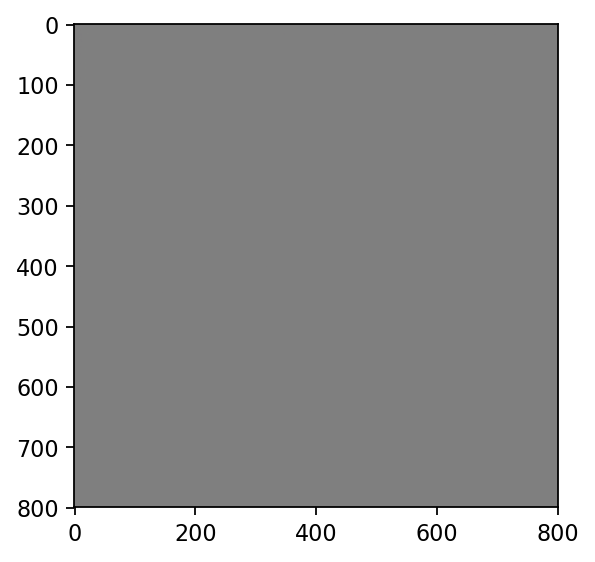

In [18]:
U.imshow(img_param.data)

In [19]:
print(img_param.size())
run_epochs(model, 400, img_param, optimizer, s_losses, c_losses, print_every=50)

torch.Size([3, 800, 800])
Epoch #0 Content Loss: 0.11425159871578217 Style Loss: 0 Total Loss: 0.11425159871578217
Epoch #50 Content Loss: 0.11390623450279236 Style Loss: 0 Total Loss: 0.11390623450279236
Epoch #100 Content Loss: 0.1134568303823471 Style Loss: 0 Total Loss: 0.1134568303823471
Epoch #150 Content Loss: 0.11291488260030746 Style Loss: 0 Total Loss: 0.11291488260030746
Epoch #200 Content Loss: 0.11229938268661499 Style Loss: 0 Total Loss: 0.11229938268661499
Epoch #250 Content Loss: 0.11165649443864822 Style Loss: 0 Total Loss: 0.11165649443864822
Epoch #300 Content Loss: 0.11101417243480682 Style Loss: 0 Total Loss: 0.11101417243480682
Epoch #350 Content Loss: 0.11035386472940445 Style Loss: 0 Total Loss: 0.11035386472940445


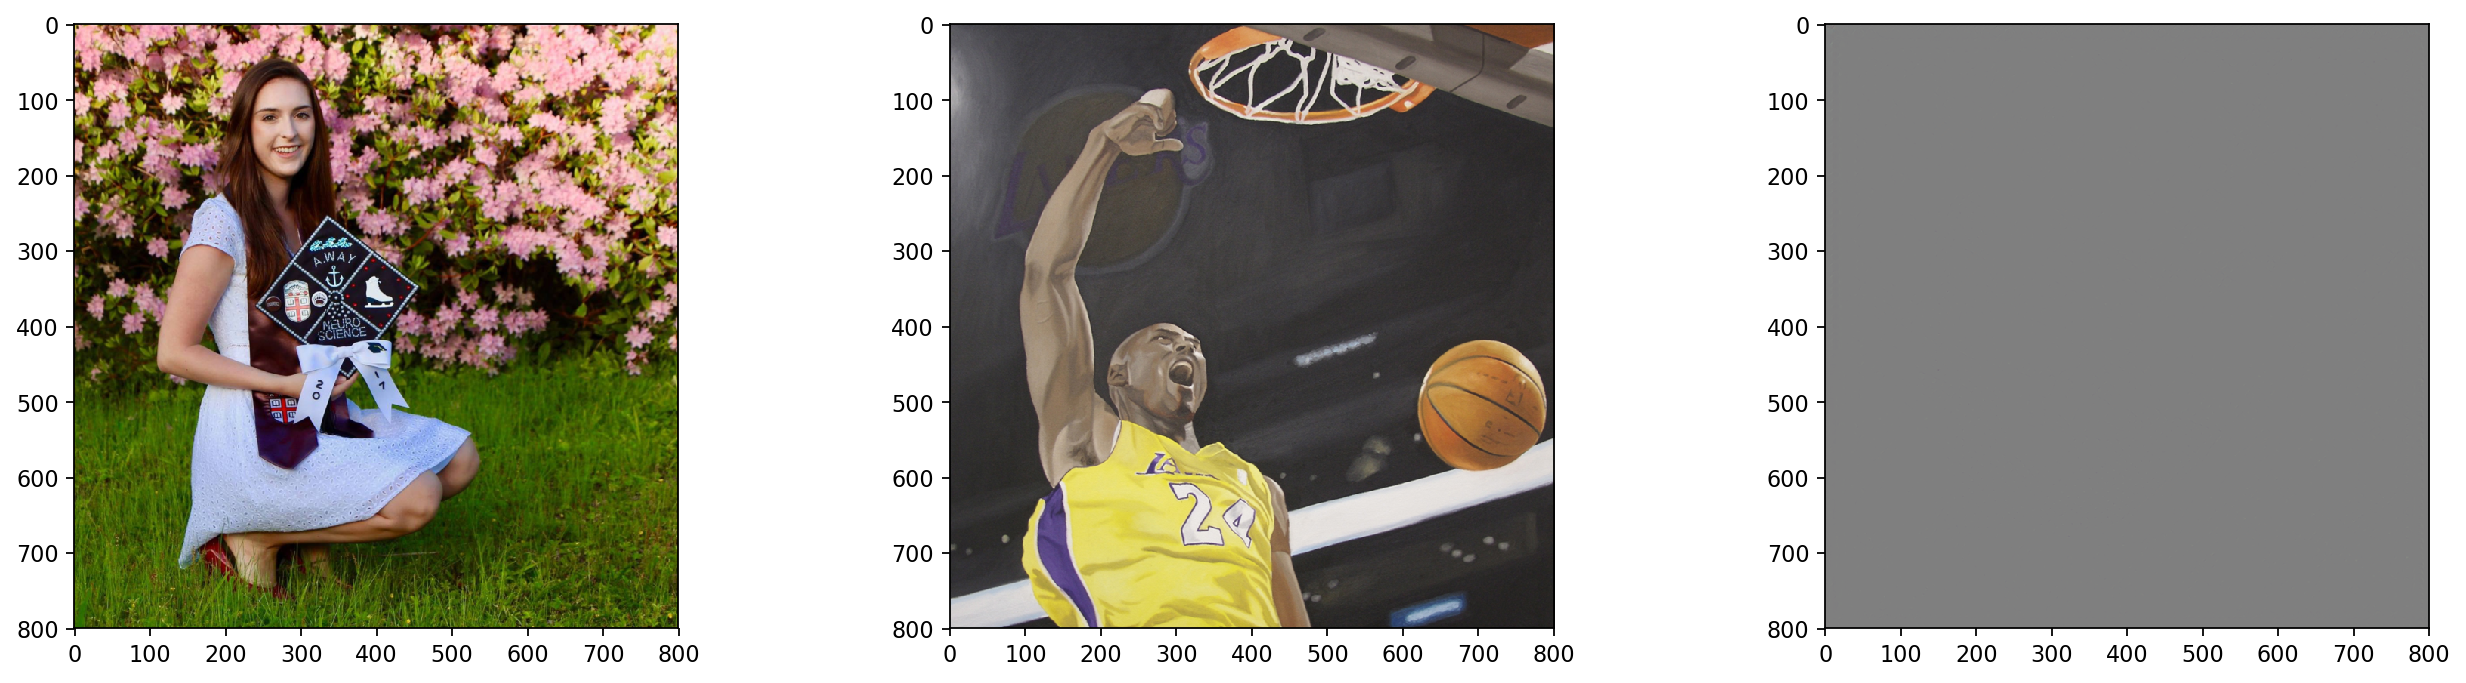

In [20]:
show_results(content_image, style_image, img_param)

# #2

In [ ]:
style_image  = Variable(U.get_image(9, 84)).cuda()
content_image = Variable(U.get_image(3, None)).cuda()
print(content_image.size())
model, c_losses, s_losses = build_model(densenet, content_layers, style_layers, content_image, style_image)
img_param, optimizer = build_optimizer(content_image.data, lr=1)

In [ ]:
run_epochs(model, 15000, img_param, optimizer, s_losses, c_losses, print_every=2500)

In [ ]:
show_results(content_image, style_image, img_param)

# #3

In [ ]:
style_image  = Variable(U.get_image(6, 54)).cuda()
content_image = Variable(U.get_image(1, 91, None)).cuda()
print(content_image.size())
print(style_image.size())
model, c_losses, s_losses = build_model(vgg, content_layers, style_layers, content_image, style_image)
img_param, optimizer = build_optimizer(content_image.data, lr=1)

In [ ]:
run_epochs(model, 3000, img_param, optimizer, s_losses, c_losses, print_every=1000)

In [ ]:
show_results(content_image, style_image, img_param)